# This is my project for computational intelligence based on kaggle dataset of monkeys.

In [1]:
# Import packages


import os
from pathlib import Path

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import applications
from keras.utils import np_utils
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.layers import (
    Conv2D,
    Activation,
    MaxPooling2D,
    Dropout,
    Flatten,
    Dense, GlobalAveragePooling2D,
)
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

Set data folders

In [2]:
data_folder = "data"
training_directory = os.path.join(data_folder, "training", "training")
test_directory = os.path.join(data_folder, "validation", "validation")
labels_file = os.path.join(data_folder, "monkey_labels.txt")

Read labels

In [3]:
labels_df = pd.read_csv(labels_file)
labels_df = labels_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
labels_df.columns = labels_df.columns.str.strip()
labels = labels_df["Common Name"]

### Read images from files

In [4]:
def convert_image_to_vector(input_image, size):
    resized_image = cv2.resize(input_image, size)
    return resized_image


def convert_image_to_vector_rgb(input_image, size):
    resized_image = cv2.resize(input_image, size)
    img_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    return img_rgb


def convert_image_to_vector_cubic(input_image, size):
    resized_image = cv2.resize(input_image, size, interpolation=cv2.INTER_CUBIC)
    return resized_image


def convert_image_to_vector_both(input_image, size):
    resized_image = cv2.resize(input_image, size, interpolation=cv2.INTER_CUBIC)
    img_rgb_cubic = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    return img_rgb_cubic


def normalize(input_image):
    mean, std = input_image.mean(), input_image.std()
    input_image = (input_image - mean) / std
    return input_image


def process_image(file, size):
    image_file = cv2.imread(file)
    image_pixels = convert_image_to_vector_both(image_file, size=size)
    image_pixels = normalize(image_pixels)
    image_label = file.split(os.path.sep)[-2][1]
    return image_pixels, image_label

In [5]:
IMG_SIZE = 128
size = (IMG_SIZE, IMG_SIZE)

training_images = []
training_images_flattened = []
training_labels = []

for path in Path(training_directory).rglob("*.jpg"):
    image, label = process_image(str(path), size)
    training_images.append(image)
    training_images_flattened.append(image.flatten())
    training_labels.append(label)

test_images = []
test_images_flattened = []
test_labels = []

for path in Path(test_directory).rglob("*.jpg"):
    image, label = process_image(str(path), size)
    test_images.append(image)
    test_labels.append(label)
    test_images_flattened.append(image.flatten())

### Plot data structure

<AxesSubplot:xlabel='Common Name'>

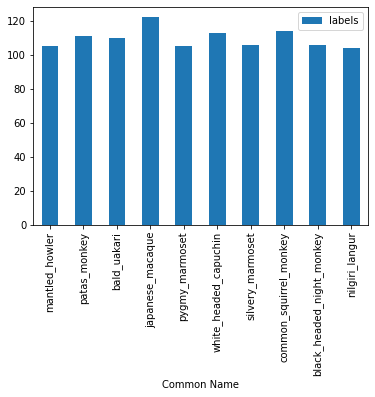

In [6]:
df = pd.DataFrame()
df["labels"] = training_labels
lab = df["labels"]

counts = lab.value_counts()
counts = pd.DataFrame(counts)
counts.index.astype(int)
counts = counts.sort_index()
counts.reset_index(drop=True, inplace=True)

training_labels_df = pd.DataFrame(labels)
training_labels_df.reset_index(drop=True, inplace=True)
training_labels_df = training_labels_df.merge(counts, left_index=True, right_index=True, how="left")
training_labels_df.set_index("Common Name", inplace=True)
training_labels_df.plot(kind="bar")

272


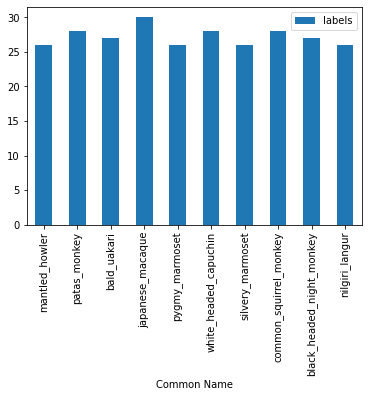

In [7]:
df = pd.DataFrame()
df["labels"] = test_labels
lab = df["labels"]
counts = lab.value_counts()
counts = pd.DataFrame(counts)
counts.index.astype(int)
counts = counts.sort_index()
counts.reset_index(drop=True, inplace=True)
test_labels_df = pd.DataFrame(labels)
test_labels_df.reset_index(drop=True, inplace=True)
test_labels_df = test_labels_df.merge(counts, left_index=True, right_index=True, how="left")
test_labels_df.set_index("Common Name", inplace=True)
test_labels_df.plot(kind="bar")
print(len(test_labels))

In [8]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_images_flattened = np.array(test_images_flattened)
training_labels_for_flattened = training_labels

training_images = np.array(training_images)
training_labels = np.array(training_labels)
training_images_flattened = np.array(training_images_flattened)
test_labels_for_flattened = test_labels

num_classes = len(np.unique(training_labels))
label_encoder = LabelEncoder()
training_labels = label_encoder.fit_transform(training_labels)
test_labels = label_encoder.fit_transform(test_labels)
test_labels = np_utils.to_categorical(test_labels, num_classes)
training_labels = np_utils.to_categorical(training_labels, num_classes)

### Test linear and logistic regression using SGD classifier

In [9]:
# sgd_lin = SGDClassifier(max_iter=1000, tol=1e-3)
# sgd_lin.fit(training_images_flattened, training_labels_for_flattened)
# y_pred = sgd_lin.predict(test_images_flattened)
# print(
#     'SGD-linear percentage correct: ',
#     100*np.sum(y_pred == test_labels_for_flattened)/len(test_labels_for_flattened)
# )

In [10]:
# sgd_log = SGDClassifier(loss="log", max_iter=1000, tol=1e-3)
# sgd_log.fit(training_images_flattened, training_labels_for_flattened)
# y_pred = sgd_log.predict(test_images_flattened)
# print(
#     'SGD-logistic percentage correct: ',
#     100*np.sum(y_pred == test_labels_for_flattened)/len(test_labels_for_flattened)
# )

### Test KNN classifier

In [11]:
# model7 = KNeighborsClassifier(n_neighbors=7)
# model14 = KNeighborsClassifier(n_neighbors=14)
# model2 = KNeighborsClassifier(n_neighbors=2)
# model1 = KNeighborsClassifier(n_neighbors=1)
#
# model1.fit(training_images_flattened, training_labels)
# model2.fit(training_images_flattened, training_labels)
# model7.fit(training_images_flattened, training_labels)
# model14.fit(training_images_flattened, training_labels)
#
# acc1 = model1.score(test_images_flattened, test_labels)
# acc2 = model2.score(test_images_flattened, test_labels)
# acc7 = model7.score(test_images_flattened, test_labels)
# acc14 = model14.score(test_images_flattened, test_labels)
#
# print("Accuracy for 1n: {:.2f}%".format(acc1 * 100))
# print("Accuracy for 2n: {:.2f}%".format(acc2 * 100))
# print("Accuracy for 7n: {:.2f}%".format(acc7 * 100))
# print("Accuracy for 14n: {:.2f}%".format(acc14 * 100))

In [12]:
image_data_generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = "nearest",
    validation_split=0.2
)

train_set = image_data_generator.flow_from_directory(
    training_directory,
    target_size = size,
    batch_size=32,
    seed = 42,
    subset="training",
    shuffle = True,
    class_mode="categorical"
)

val_set = image_data_generator.flow_from_directory(
    training_directory,
    target_size = size,
    batch_size=32,
    seed = 42,
    subset="validation",
    shuffle = True,
    class_mode="categorical"
)


test_set = image_data_generator.flow_from_directory(
    test_directory,
    target_size = size,
    batch_size = 32,
    seed = 42,
    class_mode = "categorical",
    shuffle = False
)

Found 881 images belonging to 10 classes.
Found 217 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


### Implement models

In [13]:
base_resnet_model = applications.resnet50.ResNet50(
    weights=None,
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
x = base_resnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
resnet_model = Model(inputs = base_resnet_model.input, outputs = predictions)
resnet_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
resnet_model.summary()
keras.utils.plot_model(resnet_model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 61, 61, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        1

### Fit models


In [15]:
EPOCHS = 30

es = EarlyStopping(
    monitor="loss",
    mode="auto",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor = "loss",
    factor = 0.3,
    patience = 3,
    min_lr = 1e-5,
    mode = "auto",
    verbose = 1
)

In [16]:
resnet_model.fit(
    train_set,
    validation_data=val_set,
    epochs=EPOCHS,
    callbacks=[es, ]
)

Epoch 1/30
28/28 [==============================] - 147s 5s/step - loss: 4.4233 - accuracy: 0.1238 - val_loss: 45963.3320 - val_accuracy: 0.1014
Epoch 2/30
28/28 [==============================] - 137s 5s/step - loss: 3.2021 - accuracy: 0.1790 - val_loss: 260.9555 - val_accuracy: 0.0968
Epoch 3/30
28/28 [==============================] - 136s 5s/step - loss: 2.8812 - accuracy: 0.2499 - val_loss: 9.2762 - val_accuracy: 0.1106
Epoch 4/30
28/28 [==============================] - 137s 5s/step - loss: 3.4865 - accuracy: 0.2325 - val_loss: 40.3190 - val_accuracy: 0.0691
Epoch 5/30
28/28 [==============================] - 142s 5s/step - loss: 2.4081 - accuracy: 0.2663 - val_loss: 10.2811 - val_accuracy: 0.1382
Epoch 6/30
28/28 [==============================] - 151s 5s/step - loss: 2.3073 - accuracy: 0.3141 - val_loss: 2.2473 - val_accuracy: 0.2442
Epoch 7/30
28/28 [==============================] - 142s 5s/step - loss: 2.1532 - accuracy: 0.3506 - val_loss: 2.2473 - val_accuracy: 0.2765
Epoch

In [17]:
resnet_model.save(f"ModelResNet{IMG_SIZE}im_genwithout_rl.h5")

In [18]:
model.fit(
    train_set,
    validation_data=val_set,
    epochs=EPOCHS,
    callbacks=[es,]
)

Epoch 1/30
28/28 [==============================] - 27s 910ms/step - loss: 29.3291 - accuracy: 0.1176 - val_loss: 2.2633 - val_accuracy: 0.1521
Epoch 2/30
28/28 [==============================] - 24s 863ms/step - loss: 2.2877 - accuracy: 0.1423 - val_loss: 2.2730 - val_accuracy: 0.1429
Epoch 3/30
28/28 [==============================] - 24s 862ms/step - loss: 2.2541 - accuracy: 0.1918 - val_loss: 2.1735 - val_accuracy: 0.1843
Epoch 4/30
28/28 [==============================] - 24s 882ms/step - loss: 2.1654 - accuracy: 0.2249 - val_loss: 2.1829 - val_accuracy: 0.2028
Epoch 5/30
28/28 [==============================] - 24s 856ms/step - loss: 2.1744 - accuracy: 0.2142 - val_loss: 2.2065 - val_accuracy: 0.1935
Epoch 6/30
28/28 [==============================] - 24s 853ms/step - loss: 2.1877 - accuracy: 0.2009 - val_loss: 2.1399 - val_accuracy: 0.2074
Epoch 7/30
28/28 [==============================] - 24s 845ms/step - loss: 2.1580 - accuracy: 0.1937 - val_loss: 2.0921 - val_accuracy: 0.207

In [19]:
model.save(f"ModelSimple{IMG_SIZE}im_genwithout_rl.h5")

### Test models

Residual Network model

In [20]:
print(resnet_model.evaluate(test_set, verbose=2))

9/9 - 9s - loss: 2.0391 - accuracy: 0.2684
[2.039066791534424, 0.26838234066963196]


Simple model

In [21]:
print("Testing simple")
test_loss, test_acc = model.evaluate(
    test_set,
    verbose=2
)
print("\nTest accuracy:", test_acc)


Testing simple
9/9 - 5s - loss: 1.8398 - accuracy: 0.2868

Test accuracy: 0.2867647111415863


### Test on one image

In [22]:
n = 200
test_image = test_images[n]
test_image = np.expand_dims(test_image, axis=0)
prediction = model.predict(test_image, batch_size=1)
print(labels[np.argmax(prediction)])
print(labels)

japanese_macaque
0               mantled_howler
1                 patas_monkey
2                  bald_uakari
3             japanese_macaque
4               pygmy_marmoset
5        white_headed_capuchin
6             silvery_marmoset
7       common_squirrel_monkey
8    black_headed_night_monkey
9               nilgiri_langur
Name: Common Name, dtype: object


Test saved models

In [23]:
# model3232first = tf.keras.models.load_model("Model323232firstsimple.h5")
# model3232first.summary()
# model3232first.evaluate(test_images, test_labels, verbose=2)
#

In [24]:
# model3232first_without_rl = tf.keras.models.load_model("Model323232firstsimple2without_rl.h5")
# model3232first_without_rl.summary()
# model3232first_without_rl.evaluate(test_images, test_labels, verbose=2)
#

In [25]:
# model3232second = tf.keras.models.load_model("Model323232second2without_rl.h5")
# model3232first_without_rl.evaluate(test_set, verbose=2)